## Preprocess data
Read adata of ATAC-seq and RNA-seq and save them as sparse data and annotations.

In [1]:
from scipy.io import mmwrite
import anndata 
donor_id = 'donor_0'

### ATAC-seq

In [14]:
# python
adata_peaks = anndata.read(f'../output/scATAC/adata_{donor_id}.h5ad')
# save sparse matrix
mmwrite("../output/scATAC/matrix_annot/X_matrix.mtx", adata_peaks.X)
# save annotation
annotation_peak = adata_peaks.var.reset_index().location.str.split(':', expand=True)
annotation_peak.columns = ['seqname', 'ranges']
annotation_peak['strand'] = '+' #TODO: fix this
annotation_peak.to_csv("../output/scATAC/matrix_annot/annotation_peak.csv")

annotation_cells = adata_peaks.obs.reset_index()
annotation_cells.to_csv("../output/scATAC/matrix_annot/annotation_cells.csv")

### RNA-seq

In [10]:
adata_rna = anndata.read(f'../output/scRNA/adata_{donor_id}.h5ad')
# save sparse matrix
mmwrite("../output/scRNA/matrix_annot/X_matrix.mtx", adata_rna.X)
# save annotation
annotation_gene = adata_rna.var.reset_index()
annotation_gene.to_csv("../output/scRNA/matrix_annot/annotation_gene.csv")

annotation_cells = adata_rna.obs.reset_index()[['obs_id','cell_type']]
annotation_cells.to_csv("../output/scRNA/matrix_annot/annotation_cells.csv")

In [44]:
annotation_peak.seqname == 'GL'

0         False
1         False
2         False
3         False
4         False
          ...  
135234    False
135235    False
135236    False
135237    False
135238    False
Name: seqname, Length: 135239, dtype: bool

## cell-topic probability scores 

In [ ]:
import pickle
cistopic_obj = pickle.load(
            open('../output/scATAC/cistopic_obj.pkl', 'rb'))
# get cell topic association 
cell_topic = cistopic_obj.selected_model.cell_topic.T
# remove donor name from the index
cell_topic.index = cell_topic.reset_index()['index'].apply(lambda name: name.split('__')[0])

In [54]:
cell_topic.to_csv('../output/FigR/cell_topic.csv')

# Pipeline of FigR

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R 
options(digits=5, max.print=100)  # Adjust numbers as needed
set.seed(123)

library(dplyr)
library(FNN)
library(chromVAR)
library(doParallel)
library(BuenColors)
library(FigR)
library(BSgenome.Hsapiens.UCSC.hg38)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
Loading required package: MASS

Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select

Loading required package: ggplot2
Loading required package: Matrix
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘matrixStats’

The following object is masked from ‘package:dplyr’:

    count


Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps,

## Load atac-seq and create summarizedexperiment

In [4]:
%%R 
X <- readMM("../output/scATAC/matrix_annot/X_matrix.mtx")
X <- t(X)
annotation_peak <- read.csv("../output/scATAC/matrix_annot/annotation_peak.csv", row.names = 1)
annotation_cells <- read.csv("../output/scATAC/matrix_annot/annotation_cells.csv", row.names = 1)

# Filter out entries where seqname is 'chr10'
filter_indices <- grepl("^chr", annotation_peak$seqname)
annotation_peak_filtered <- annotation_peak[filter_indices, ]

# Filter the rows in X
X_filtered <- X[filter_indices, ]

# Create the SummarizedExperiment object with the filtered data
atac <- SummarizedExperiment(assays = list(counts = X_filtered), 
                             rowRanges = GRanges(annotation_peak_filtered$seqname,
                              IRanges(annotation_peak_filtered$ranges)), 
                             colData = DataFrame(annotation_cells))
colnames(atac) <- annotation_cells$obs_id    

dim(atac) #peaks*cells

[1] 135180   7830


### Load RNA-seq and create sparsematrix

In [5]:
%%R 
XX <- readMM("../output/scRNA/matrix_annot/X_matrix.mtx")
XX <- t(XX)
annotation_gene <- read.csv("../output/scRNA/matrix_annot/annotation_gene.csv", row.names = 1)
annotation_cells <- read.csv("../output/scRNA/matrix_annot/annotation_cells.csv", row.names = 1)

rna <- as(XX, "CsparseMatrix")
rownames(rna) <- annotation_gene$location
colnames(rna) <- annotation_cells$obs_id

# Remove genes with zero expression across all cells
rna <- rna[Matrix::rowSums(rna)!=0,]

dim(rna) # genes*cells

[1] 22726  7830


## load cell topic probabilities and create cell-cluster matrix


In [6]:
%%R 
n_topics = 16
cell_topic <- read.csv('../output/FigR/cell_topic.csv', row.names = 1)
# Derive cell kNN using this
cellkNN <- get.knn(cell_topic,k = n_topics)$nn.index
dim(cellkNN)
rownames(cellkNN) <- rownames(cell_topic)

## Save data

In [7]:
%%R 
n_cells_to_keep = dim(rna)[2]
cellsToKeep <- sample(colnames(atac), size = n_cells_to_keep, replace = FALSE)
atac_short = atac[, cellsToKeep]
rna_short = rna[, cellsToKeep]
cellkNN_short = cellkNN[cellsToKeep,]

saveRDS(atac_short, 'atac_short.rds')
saveRDS(rna_short, 'rna_short.rds')


In [22]:
%%R 
cellkNN_short = readRDS('cellkNN_short.rds')

## Peak-gene association testing

In [8]:
# %%R 
# options(digits=5, max.print=100)  # Adjust numbers as needed
# set.seed(123)

# library(dplyr)
# library(FNN)
# library(chromVAR)
# library(doParallel)
# library(BuenColors)
# library(FigR)
# library(BSgenome.Hsapiens.UCSC.hg38)
# atac_short = readRDS('atac_short.rds')
# rna_short  = readRDS('rna_short.rds')
# cisCorr <- FigR::runGenePeakcorr(ATAC.se = atac_short,
#                            RNAmat = rna_short,
#                            genome = "hg38", # One of hg19, mm10 or hg38 
#                            nCores = 20,
#                            p.cut = NULL, # Set this to NULL and we can filter later
#                            n_bg = 100)
# write.csv(cisCorr, "cisCorr.csv", row.names = TRUE)

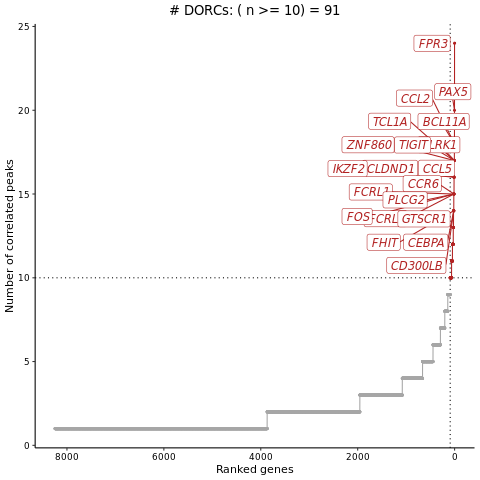

In [9]:
%%R 
cisCorr = read.csv("cisCorr.csv")
cisCorr.filt <- cisCorr %>% filter(pvalZ <= 0.05)

dorcGenes <- dorcJPlot(dorcTab = cisCorr.filt,
                         cutoff = 10, # No. sig peaks needed to be called a DORC
                         labelTop = 20,
                         returnGeneList = TRUE, # Set this to FALSE for just the plot
                         force=2)
# Unfiltered
numDorcs <- cisCorr.filt %>% group_by(Gene) %>% tally() %>% arrange(desc(n))
# numDorcs

## Create DORCs and smooth them 

In [10]:
%%R 
dorcMat <- getDORCScores(ATAC.se = atac_short, # Has to be same SE as used in previous step
                         dorcTab = cisCorr.filt,
                         geneList = dorcGenes,
                         nCores = 4)

........
Normalizing scATAC counts ..
SummarizedExperiment object input detected .. Centering counts under assayCentering counts for cells sequentially in groups of size  5000  ..

Computing centered counts for cells:  1  to  5000 ..


Computing centered counts per cell using mean reads in features ..

Computing centered counts for cells:  5001  to  7830 ..
Computing centered counts per cell using mean reads in features ..

Merging results..
Done!
Computing DORC scores ..
Running in parallel using  4 cores ..
  |=======================================================| 100%, Elapsed 00:03

Time Elapsed:  3.52997756004333 secs 



Running DORC scoring for 91 genes: FPR3, PAX5, BCL11A, CCL2, KLRK1, TCL1A, TIGIT, ZNF860, CCL5, CLDND1, IKZF2, CCR6, FCRL1, FCRL3, FOS, PLCG2, CD300LB, CEBPA, FHIT, GTSCR1, ... , ... , ... (truncated display)


In [11]:
%%R 
# Smooth dorc scores using cell KNNs (k=n_topics)
dorcMat.s <- smoothScoresNN(NNmat = cellkNN_short[,1:n_topics], mat = dorcMat,nCores = 4)

# Smooth RNA using cell KNNs
# This takes longer since it's all genes
RNAmat.s <- smoothScoresNN(NNmat = cellkNN_short[,1:n_topics],mat = rna_short,nCores = 4)

Number of cells in supplied matrix:  7830 
Number of genes in supplied matrix:  91 
Number of nearest neighbors being used per cell for smoothing:  16 
  |                                                                      |   0%

Running in parallel using  4 cores ..
  |======================================================================| 100%
Merging results ..

Time Elapsed:  18.5206196308136 secs 
Number of cells in supplied matrix:  7830 
Number of genes in supplied matrix:  22726 
Number of nearest neighbors being used per cell for smoothing:  16 
Running smoothing for all genes in matrix! (n = 22726) This is bound to take more time than querying specific markers ..
  |                                                                      |   0%Running in parallel using  4 cores ..
  |======================================================================| 100%
Merging results ..

Time Elapsed:  1.70692023038864 mins 


In [20]:
%%R # save it as we will need it for TF gene associations 
write.csv(cisCorr.filt, 'cisCorr.filt.csv')
saveRDS(RNAmat.s, 'RNAmat.s.RDS')
saveRDS(dorcMat.s, 'dorcMat.s.RDS')


## TF-gene associations

In [ ]:
%%R 
cisCorr.filt = read.csv('cisCorr.filt.csv')
RNAmat.s = readRDS('RNAmat.s.RDS')
dorcMat.s = readRDS('dorcMat.s.RDS')
atac_short = readRDS('atac_short.rds')
figR.d <- runFigRGRN(ATAC.se = atac_short, # Must be the same input as used in runGenePeakcorr()
                     dorcTab = cisCorr.filt, # Filtered peak-gene associations
                     genome = "hg38",
                     dorcMat = dorcMat.s,
                     rnaMat = RNAmat.s, 
                     nCores = 30)
write.csv(figR.d, 'figR.d.csv')

Getting peak x motif matches ..
Determining background peaks ..
Using  50  iterations ..

Testing  820  TFs
Testing  91  DORCs
  |                                                                      |   0%

: 

In [ ]:
%%R 
figR.d = read.csv('figR.d.csv')

figR.d %>% 
  ggplot(aes(Corr.log10P,Enrichment.log10P,color=Score)) + 
  ggrastr::geom_point_rast(size=0.01,shape=16) + 
  theme_classic() + 
  scale_color_gradientn(colours = jdb_palette("solar_extra"),limits=c(-3,3),oob = scales::squish,breaks=scales::breaks_pretty(n=3))

In [ ]:
%%R 
rankDrivers(figR.d,rankBy = "meanScore",interactive = FALSE)

# Example of FigR

In [ ]:
%%R 
workingDir <- "../output/FigR"
dataDir <- "../input/FigR/FigR_SHAREseq"

ATAC.se <- readRDS(paste0(dataDir, "/shareseq_skin_SE_final.rds"))
RNAmat <- readRDS(paste0(dataDir, "/shareseq_skin_RNAnorm_final.rds"))

# dim(ATAC.se) # Peaks x Cells
# RNAmat[1:10, 1:10] # Genes x Cells

In [ ]:
%%R 
cellsToKeep <- sample(colnames(ATAC.se),size = 1000,replace = FALSE)
ATAC.se <- ATAC.se[,cellsToKeep]
RNAmat <- RNAmat[,cellsToKeep]
# Remove genes with zero expression across all cells
RNAmat <- RNAmat[Matrix::rowSums(RNAmat)!=0,]

In [ ]:
%%R 
cisAssign <- readRDS(paste0(dataDir, "/shareseq_skin_cisTopicPs.rds"))
# Subset
cisAssign <- cisAssign[cellsToKeep,]

In [ ]:
%%R 
cisCorr <- FigR::runGenePeakcorr(ATAC.se = ATAC.se,
                           RNAmat = RNAmat,
                           genome = "mm10", # One of hg19, mm10 or hg38 
                           nCores = 4,
                           p.cut = NULL, # Set this to NULL and we can filter later
                           n_bg = 100)

Matrix object input detectedCentering counts for cells sequentially in groups of size  1000  ..

Computing centered counts for cells:  1  to  1000 ..
Computing centered counts per cell using mean reads in features ..

Merging results..
Done!
Number of peaks in ATAC data: 316435 
Number of genes in RNA data: 15730 

Num genes overlapping TSS annotation and RNA matrix being considered:  14772 

Taking peak summits from peak windows ..
Finding overlapping peak-gene pairs ..
Found  400531 total gene-peak pairs for given TSS window ..
Number of peak summits that overlap any gene TSS window:  203970 
Number of gene TSS windows that overlap any peak summit:  14463 

Determining background peaks ..
Using  100  iterations ..

Computing gene-peak correlations ..
Running pairs:  1 to 5000 
Running in parallel using  4 cores ..
Computing observed correlations ..
  |=======================================================| 100%, Elapsed 00:00
Finished!

Time Elapsed:  0.515427350997925 secs 

Comput

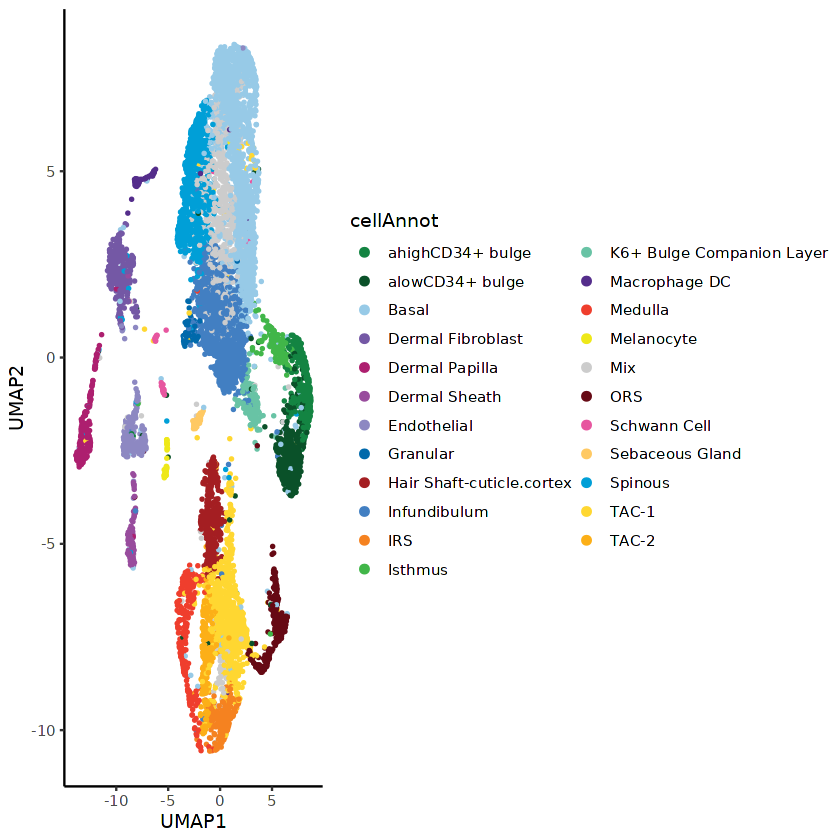

In [ ]:
annoCols <- readRDS(paste0(dataDir, "/shareseq_skin_annoCols.rds"))

# Plot
library(ggplot2)
colData(ATAC.se) %>% as.data.frame() %>% ggplot(aes(UMAP1,UMAP2,color=cellAnnot)) + 
  geom_point(size=0.5) + scale_color_manual(values=annoCols)+
  theme_classic() + guides(colour = guide_legend(override.aes = list(size=2)))